In [44]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt

import copy


# Sample data
data = {
    'x': [1, 2, 2, 8, 8, 25],
    'y': [2, 2, 3, 8, 9, 30]
}

# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_2nuBB_slim.h5","hits")

# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim.h5","MC/hits")
hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim_smear.h5","hits")
display(hits)


,event_id,x,y,z,energy
0,0,-7.278010,5.699774,3001.824951,0.003125
1,0,-8.744831,6.098631,3002.756836,0.000600
2,0,-10.577087,6.596858,3003.920898,0.001850
3,0,-12.899525,7.228374,3005.396484,0.001500
4,0,-14.457469,7.634260,3006.411621,0.000925
...,...,...,...,...,...
1014,9,-1.566567,6.041556,2994.062988,0.001375
1015,9,-0.845645,5.452194,2995.227539,0.001700
1016,9,0.166640,4.618393,2996.852295,0.000125
1017,9,0.988774,3.951444,2998.179199,0.002775


,event_id,x,y,z,energy
966,8,-10.136497,3.766285,2978.322754,0.005925
967,8,-10.837481,5.236767,2979.348389,0.001675
968,8,-8.446585,3.133086,2979.635254,0.001275
969,8,-10.693833,7.341651,2980.207031,0.006125
970,8,-9.390941,10.461720,2980.769043,0.007425
971,8,-9.808539,13.592598,2980.835205,0.007525
972,8,-7.124098,2.906360,2981.014160,0.000300
973,8,-10.182403,19.584419,2981.867920,0.004775
974,8,-5.857797,2.829066,2981.927490,0.011175
975,8,-6.101520,2.765849,2982.113770,0.000100


,x,y,z,energy
0,-8.574442,16.481607,2985.994385,0.005050
1,-8.446585,3.133086,2979.635254,0.001275
2,-3.794839,5.573818,2995.224365,0.006925
3,-9.152857,14.579811,2983.933350,0.006525
4,-12.427312,19.727465,2984.823730,0.004025
5,-7.124098,2.906360,2981.014160,0.000300
6,-10.182403,19.584419,2981.867920,0.004775
7,-10.136497,3.766285,2978.322754,0.005925
8,-2.758884,5.102602,2987.800049,0.000375
9,-5.857797,2.829066,2981.927490,0.011175


{0: [23, 21], 23: [0, 10], 1: [5], 5: [1, 16], 2: [14], 14: [2, 20], 3: [10], 10: [3, 23], 4: [12], 12: [4, 13], 16: [5, 9], 6: [22], 22: [6], 7: [17], 17: [7, 11], 8: [27, 24], 27: [8, 18], 9: [16], 11: [17], 13: [12], 20: [14, 20, 20], 15: [28], 28: [15], 18: [27], 19: [25], 25: [19], 21: [0], 24: [8]}
[2 1 1 1 1 2 1 1 2 1 2 1 2 1 2 1 2 2 1 1 3 1 1 2 1 1 0 2 1]
[2 1 1 1 1 2 1 1 2 1 2 1 2 1 2 1 2 2 1 1 3 1 1 2 1 1 0 2 1]


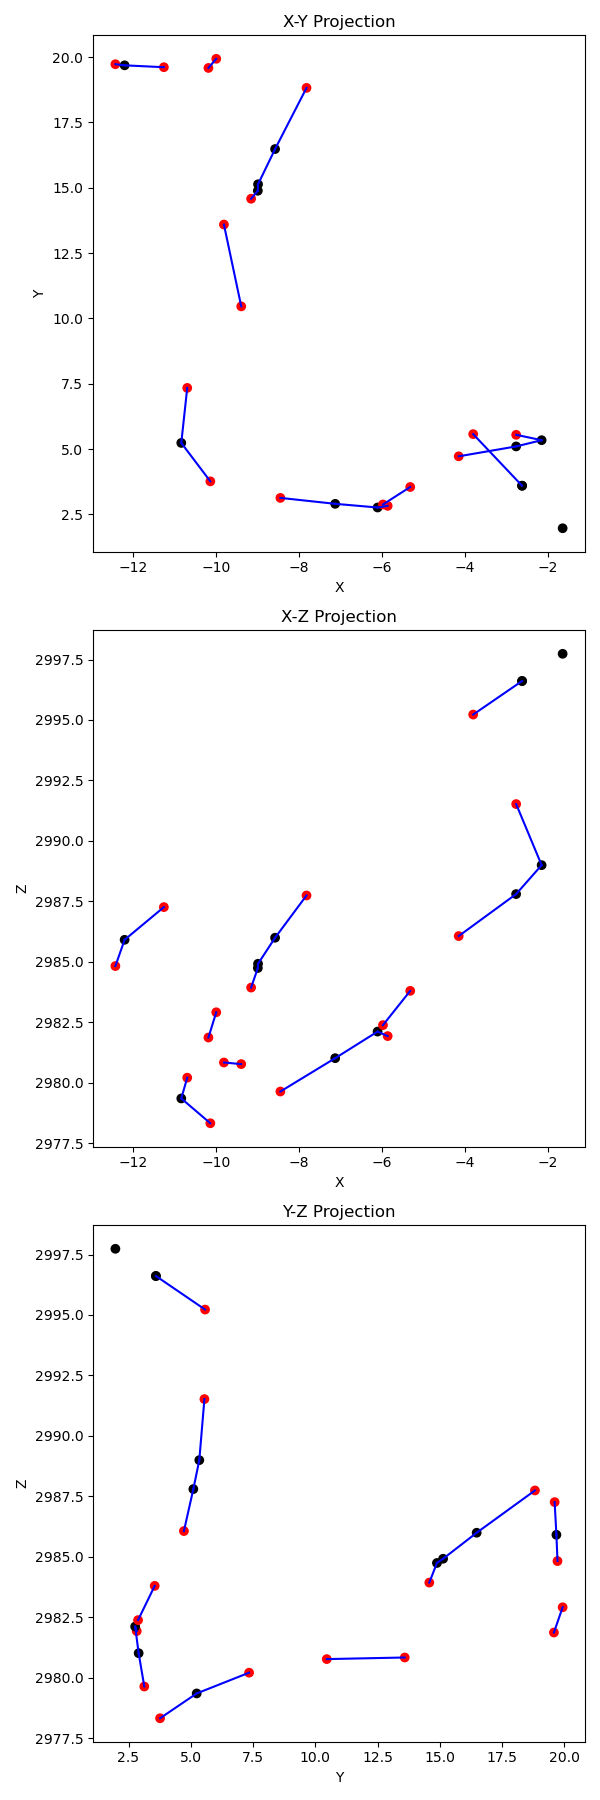

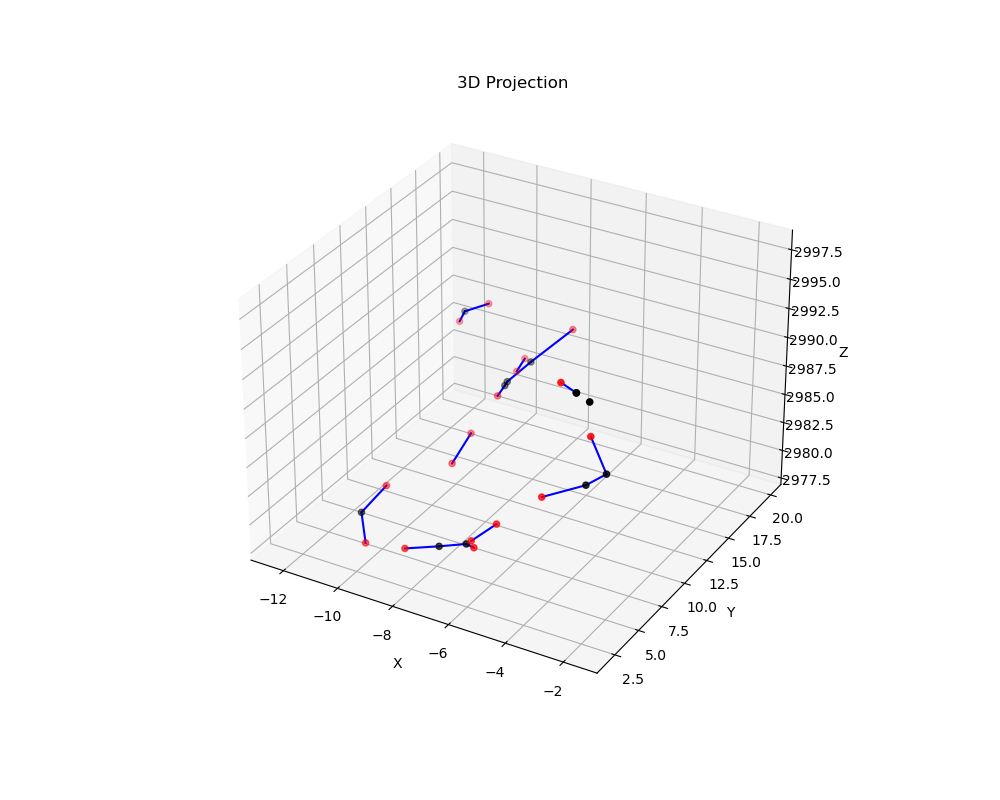

In [82]:
%matplotlib widget

data = hits[hits.event_id == 8]
display(data)
data = data[['x', 'y', 'z',"energy"]]

# shuffle the data to ensure we dont use g4 ordering
data = data.sample(frac=1).reset_index(drop=True)

# then sort it based on the x,y,z
# data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)

display(data)


df = pd.DataFrame(data)

# Calculate the distance matrix
dist_matrix = distance_matrix(data[['x', 'y', 'z']], data[['x', 'y', 'z']])

# Initialize connections counter, keeps track of number of connections to each index
connection_count = np.zeros(len(data), dtype=int)

# This is a dict, format is
# index : [connected node 1, connected node 2,...]
connected_nodes = {}

# Define angle threshold in degrees
angle_threshold = 0.5  # Change this value as needed
angle_threshold = np.deg2rad(angle_threshold)

# Function to calculate the angle between two vectors
def calculate_angle(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    angle = np.arccos(dot_product / (norm_v1 * norm_v2))
    return angle

# Function to add connections made
# current and current node index is input
def UpdateConnections(curr_node_idx, conn_node_idx, connected_nodes_, connections_, connection_count_):
    # Add connection between node i and closest_idx
    connections_.append((curr_node_idx, conn_node_idx))
    connection_count_[curr_node_idx] += 1
    connection_count_[conn_node_idx] += 1
    
    # Update connected nodes
    if i in connected_nodes_:
        connected_nodes_[curr_node_idx].append(conn_node_idx)
    else:
        connected_nodes_[curr_node_idx] = [conn_node_idx]
    
    if conn_node_idx in connected_nodes_:
        connected_nodes_[conn_node_idx].append(curr_node_idx)
    else:
        connected_nodes_[conn_node_idx] = [curr_node_idx]

# Function to check if a new connection would form a closed loop
def forms_cycle(node, target, connections_dict):

    query = node
    prev_node = node 
    # print(query)

    for index,n in enumerate(range(len(connections_dict))):
        
        # Get the connected nodes
        con_nodes = connections_dict[query]
        # print("Start",query, prev_node, con_nodes)

        # We hit a end-point and it didnt loop
        if (len(con_nodes) == 1):
            return False

        # Get the node that went in the query before
        if con_nodes[1] == prev_node:
            prev_node = query
            query = con_nodes[0]
        else:
            prev_node = query
            query = con_nodes[1]

        if (index == 0):
            query = con_nodes[0]
            prev_node = node


        # If the returned query value is the target then we have looped
        if (query == target):
            return True

    # We looped over everything and found no loops
    return False
    


# Find closest nodes and create connections
connections = []
for i in range(len(data)):
    # Find the index of the closest node (excluding itself)
    closest_idx = np.argpartition(dist_matrix[i], 1)[1]
    
    # Check if the connection already exists
    if closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, [])  and connection_count[closest_idx] <= 1 and connection_count[i] <= 1:
        
        # Add connection between node i and closest_idx
        UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)


print(connected_nodes)

print(connection_count)


# temp_connections_dict = connected_nodes.copy()
# temp_connection_count = connection_count.copy()
# temp_connections      = connections.copy()
# UpdateConnections(0,3, temp_connections_dict, temp_connections, temp_connection_count)
# cycle = forms_cycle(0,3, temp_connections_dict)
# print(cycle)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

# Connect single nodes to the next closest single node if the angle is above the threshold
for i in single_nodes:
    
    # Connections get updated, so this ensures we dont make a connection to a newly formed connection
    if connection_count[i] == 1:
        
        # Find the index of the closest node with one connection (excluding itself)
        sorted_indices = np.argsort(dist_matrix[i])
        
        for closest_idx in sorted_indices[:10]:

            # Check if the index is not itelf and the connection count of the closest index is 1
            if closest_idx != i and connection_count[closest_idx] == 1 and connection_count[i] == 1 and closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []): 
                
                if dist_matrix[i][closest_idx] < 10:

                    # Temporarily add the connection to check for cycles
                    temp_connections_dict = copy.deepcopy(connected_nodes)
                    temp_connections      = copy.deepcopy(connections)
                    temp_connection_count = copy.deepcopy(connection_count)

                    # print(i,closest_idx,connection_count[i], connection_count[closest_idx], temp_connections_dict[i], temp_connections_dict[closest_idx])
                    UpdateConnections(i, closest_idx, temp_connections_dict, temp_connections, temp_connection_count)

                    # Check for cycles
                    cycle = forms_cycle(i, closest_idx, temp_connections_dict)

                    temp_connections_dict = {}
                    temp_connections = []
                    temp_connection_count = []
                    
                    if not cycle:
                        UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)
                        break

print(connection_count)

# Function to plot connections
def plot_connections(ax, x, y, connections, connection_count, x_label, y_label):
    colors = ['r' if count == 1 else 'k' for count in connection_count]
    ax.scatter(x, y, c=colors, marker='o')
    for connection in connections:
        start_node = connection[0]
        end_node = connection[1]
        ax.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'b-')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 18))

# Plot xy projection
plot_connections(axs[0], data['x'], data['y'], connections, connection_count, 'X', 'Y')

# Plot xz projection
plot_connections(axs[1], data['x'], data['z'], connections, connection_count, 'X', 'Z')

# Plot yz projection
plot_connections(axs[2], data['y'], data['z'], connections, connection_count, 'Y', 'Z')

plt.tight_layout()
plt.show()

# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['r' if count == 1 else 'k' for count in connection_count]
ax.scatter(data['x'], data['y'], data['z'], c=colors, marker='o')
for connection in connections:
    start_node = connection[0]
    end_node = connection[1]
    ax.plot([data['x'][start_node], data['x'][end_node]],
            [data['y'][start_node], data['y'][end_node]],
            [data['z'][start_node], data['z'][end_node]], 'b-')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()